## Knowledge Distillation Techniques on MNIST

Steps:
1. Import MNIST dataset.
2. Create a teacher model.
3. Create a student model.
4. Compare results.

### Setup

In [1]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    print(device)

In [3]:
from pathlib import Path
dir_path = Path('/home/rdat/knowledge_distillation/MNIST Experiment/')

In [4]:
use_saved_teacher_model=True

### Creating the dataset

In [5]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage

In [6]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
val_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

In [7]:
print(f'Training Data Size: {train_data.data.shape}\n')
print('-----Training Data Samples-----')
for i in range(2):
    img = ToPILImage()(train_data[i][0])
    display(img)

print(f'Val Data Size: {val_data.data.shape}\n')

print('\n-----Val Data Samples-----')
for i in range(2):
    img = ToPILImage()(val_data[i][0])
    display(img)

Training Data Size: torch.Size([60000, 28, 28])

-----Training Data Samples-----


Val Data Size: torch.Size([10000, 28, 28])


-----Val Data Samples-----


In [8]:
train_batch_size = 128
val_batch_size = 128

In [9]:
dataloaders = {'train': DataLoader(dataset=train_data, batch_size=train_batch_size, shuffle=True, num_workers=8), 
               'val': DataLoader(dataset=val_data, batch_size=val_batch_size, shuffle=True, num_workers=8)}

### Creating the models

In [10]:
from torch import nn
import numpy as np

#### Teacher Model

In [11]:
class TeacherModelCls(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.output = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=1600, out_features=10))
        self.output_act = nn.Softmax(dim=1)

    def forward(self, X, use_output_act):
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.output(X)

        # Training teacher model vs. Extracting outputs before Softmax
        if use_output_act:
            X = self.output_act(X)
            return X
        
        return X

In [12]:
teacher_model_state_dict_path = dir_path/'models'/'teacher_model_state_dict.pt'

if use_saved_teacher_model:
    teacher_model = TeacherModelCls().to(device)
    teacher_model.load_state_dict(torch.load(teacher_model_state_dict_path)())
    teacher_model.eval()

##### Training Functions

In [13]:
def train_one_epoch(model, dataloader, loss_fn, optimiser, epoch, use_output_act):
    
    batch_losses = []

    for i, batch_data in enumerate(dataloader):
        X_batch, y_batch = batch_data
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimiser.zero_grad()
        
        y_batch_pred = model(X_batch, use_output_act)

        loss = loss_fn(y_batch_pred, y_batch)
        loss.backward()
        
        optimiser.step()

        batch_losses.append(loss)

    batch_losses = torch.Tensor(batch_losses)

    return batch_losses

In [14]:
def validate_one_epoch(model, dataloader, loss_fn, epoch, use_output_act):

    batch_losses = []
    batch_acc = []
    
    with torch.no_grad():
        for i, batch_data in enumerate(dataloader):
            X_batch, y_batch = batch_data

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_batch_pred = model(X_batch, use_output_act)

            loss = loss_fn(y_batch_pred, y_batch)

            batch_losses.append(loss)

            y_batch_bin_pred = torch.argmax(y_batch_pred, dim=1)

            acc = (y_batch == y_batch_bin_pred).float().mean()
            batch_acc.append(acc)
                
    batch_losses = torch.Tensor(batch_losses)
    batch_acc = torch.Tensor(batch_acc)
    
    return batch_losses, batch_acc

In [15]:
def train_model(model, dataloaders, loss_fn, optimiser, n_epochs, use_output_act):

    train_losses = []
    val_losses = []
    val_acc = []
    lrs = []

    for e in range(n_epochs):
        lrs.append(optimiser.state_dict()['param_groups'][0]['lr'])
        
        # Training for one epoch
        train_batch_losses = train_one_epoch(model, dataloaders['train'], loss_fn, optimiser, e, use_output_act)
        train_losses.append(train_batch_losses)

        # Validation for one epoch
        model.eval()

        val_batch_losses, val_batch_acc = validate_one_epoch(model, dataloaders['val'], loss_fn, e, use_output_act)
        val_losses.append(val_batch_losses)
        val_acc.append(val_batch_acc)

        if e%20 == 0:
            print(f'Epoch {e}')

    train_losses = torch.stack(train_losses).to(device)
    val_losses = torch.stack(val_losses).to(device)
    val_acc = torch.stack(val_acc).to(device)

    print('Training completed')
    return train_losses, val_losses, val_acc, lrs

##### Teacher Model Training

In [16]:
from datetime import datetime

if use_saved_teacher_model:
    print('Skipping training')
else:
    teacher_model = TeacherModelCls().to(device)
    
    n_epochs = 100
    
    dt1 = datetime.now()
    
    train_losses, val_losses, val_acc, lrs = train_model(teacher_model, dataloaders, 
                                                         loss_fn=nn.CrossEntropyLoss(), 
                                                         optimiser=torch.optim.SGD(params=teacher_model.parameters(), lr=0.25), 
                                                         n_epochs=n_epochs,
                                                         use_output_act=True)
    
    dt2 = datetime.now()
    
    print(f'Time taken: {dt2 - dt1}')

Epoch 0
Epoch 20
Epoch 40
Epoch 60
Epoch 80
Training completed
Time taken: 0:03:42.972185


In [17]:
import pandas as pd

if use_saved_teacher_model:
    print('Skipping training stats analyis')
else:
    loss_stats_df = pd.DataFrame(zip(range(n_epochs), 
                                      torch.mean(train_losses, dim=1).detach().cpu().numpy(), 
                                      torch.mean(val_losses, dim=1).detach().cpu().numpy(),
                                     ), 
                                  columns=['epoch', 'train_loss', 'val_loss'])
    
    loss_stats_df = data=pd.melt(loss_stats_df, id_vars=['epoch'], value_vars=['train_loss', 'val_loss'], value_name='loss', var_name='loss_type')
    
    acc_stats_df = pd.DataFrame(zip(range(n_epochs), torch.mean(val_acc, dim=1).detach().cpu().numpy()), columns=['epoch', 'val_acc'])
    
    lrs_df = pd.DataFrame(zip(range(n_epochs), lrs), columns=['epoch', 'lr'])

    print(loss_stats_df[loss_stats_df['epoch'] == n_epochs-1])

    print(acc_stats_df[acc_stats_df['epoch'] == n_epochs-1])

     epoch   loss_type      loss
99      99  train_loss  1.465439
199     99    val_loss  1.472067
    epoch   val_acc
99     99  0.989517


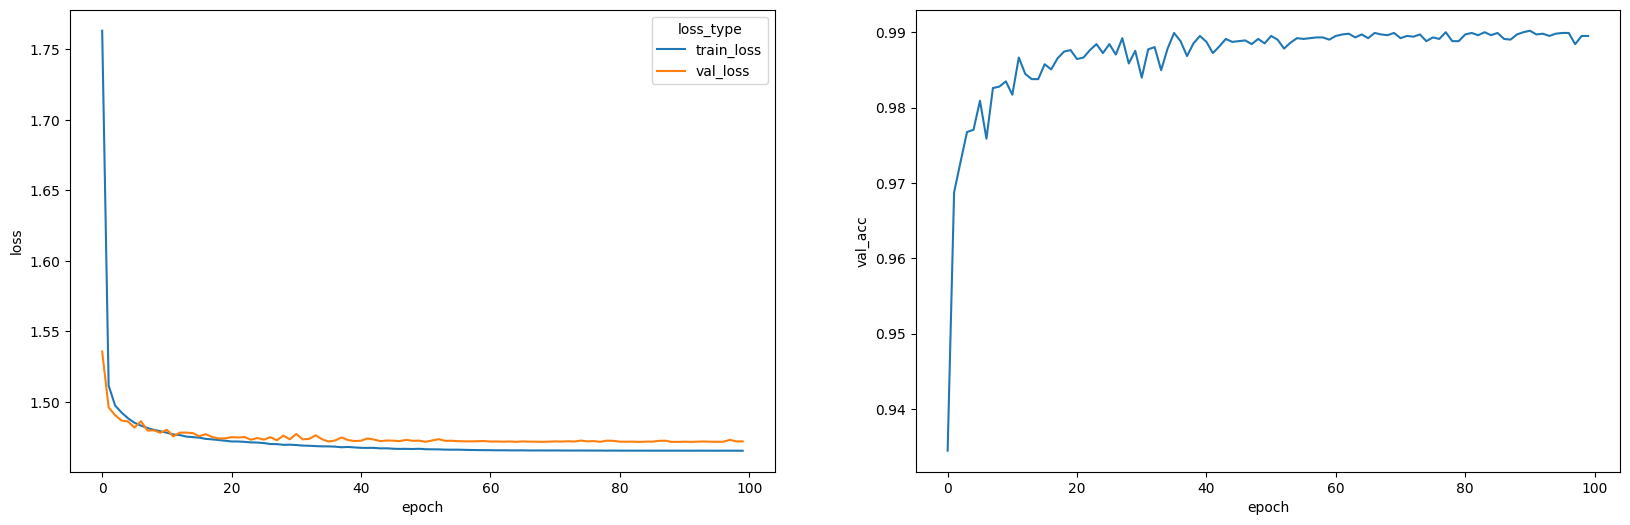

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

if use_saved_teacher_model:
    print('Skipping training stats analyis')
else:
    fig, axes = plt.subplots(1,2, figsize=(20,6))
    
    sns.lineplot(x='epoch', y='loss', hue='loss_type', data=loss_stats_df, ax=axes[0])
    sns.lineplot(x='epoch', y='val_acc', data=acc_stats_df, ax=axes[1])
    #sns.lineplot(x='epoch', y='lr', data=lrs_df, ax=axes[1][0])

In [19]:
# Saving the teacher model

if use_saved_teacher_model:
    print('Skipping model save')
else:
    torch.save(teacher_model.state_dict, f=dir_path/'models'/'teacher_model_state_dict.pt')
    print('Model saved')

Model saved


#### Student Model

1. Generate new true y values for dataloaders['train']
2. Generate new true y values for dataloaders['val']
3. Train student model on new true y values for dataloaders['train']
4. Validate student model on new true y values for dataloaders['val']

In [47]:
class StudentModelCls(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                                    )
        self.output = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=16*13*13, out_features=10),
                                    nn.Sigmoid(dim=1)
                                    )


    def forward(self, X):
        X = self.layer1(X)
        X = self.output(X)

        return X

In [44]:
with torch.no_grad():
    for i, batch_data in enumerate(dataloaders['train']):
        X_batch, _ = batch_data

        X_batch = X_batch.to(device)
        
        y_batch = teacher_model(X_batch, use_output_act=False)

        


In [ ]:
from datetime import datetime

if use_saved_teacher_model:
    print('Skipping training')
else:
    student_model = StudentModelCls().to(device)
    
    n_epochs = 100
    
    dt1 = datetime.now()
    
    train_losses, val_losses, val_acc, lrs = train_model(student_model, dataloaders, 
                                                         loss_fn=nn.CrossEntropyLoss, 
                                                         optimiser=torch.optim.SGD(params=model.parameters(), lr=0.25), 
                                                         n_epochs=n_epochs)
    
    dt2 = datetime.now()
    
    print(f'Time taken: {dt2 - dt1}')

#### Convolution experiments

In [5]:
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as F_vision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

In [65]:
img1_tensor = torchvision.io.read_image('/home/rdat/Downloads/grayscale_1.jpeg', mode=torchvision.io.ImageReadMode.GRAY).to(torch.float32).view(1, 1, 225, 225)
#img1_tensor = img1_tensor/255
img2_tensor = torchvision.io.read_image('/home/rdat/Downloads/grayscale_2.jpg', mode=torchvision.io.ImageReadMode.GRAY).to(torch.float32).view(1, 1, 225, 225)
#img2_tensor = img2_tensor/255

In [34]:
img3_tensor = torch.Tensor([[[[0, 32, 64, 96, 128, 160, 192, 224, 255], 
                              [32, 64, 96, 128, 160, 192, 224, 255, 0], 
                              [64, 96, 128, 160, 192, 224, 255, 0, 32], 
                              [96, 128, 160, 192, 224, 255, 0, 32, 64], 
                              [128, 160, 192, 224, 255, 0, 32, 64, 96], 
                              [160, 192, 224, 255, 0, 32, 64, 96, 128], 
                              [192, 224, 255, 0, 32, 64, 96, 128, 160],
                              [224, 255, 0, 32, 64, 96, 128, 160, 192],
                              [255, 0, 32, 64, 96, 128, 160, 192, 224]]]])

In [10]:
img4_tensor = torchvision.io.read_image('/home/rdat/Downloads/rgb_1.jpg', mode=torchvision.io.ImageReadMode.RGB).to(torch.float32).view(1, 3, 225, 225)

In [11]:
img4_tensor

tensor([[[[ 61.,  72.,  66.,  ...,  71.,  75.,  87.],
          [ 69.,  67.,  56.,  ...,  87.,  82.,  82.],
          [ 81.,  75.,  61.,  ...,  85.,  77.,  85.],
          ...,
          [ 24.,  27.,  29.,  ..., 111.,  75.,  61.],
          [ 26.,  26.,  29.,  ...,  95.,  77.,  65.],
          [ 32.,  31.,  29.,  ...,  96.,  88.,  77.]],

         [[ 62.,  73.,  69.,  ...,  82.,  86.,  96.],
          [ 70.,  68.,  59.,  ...,  98.,  93.,  93.],
          [ 81.,  76.,  66.,  ...,  97.,  89.,  95.],
          ...,
          [ 29.,  32.,  34.,  ...,  81.,  52.,  40.],
          [ 31.,  31.,  34.,  ...,  68.,  56.,  48.],
          [ 38.,  37.,  35.,  ...,  73.,  67.,  59.]],

         [[ 54.,  65.,  62.,  ...,  78.,  82.,  93.],
          [ 62.,  60.,  52.,  ...,  94.,  89.,  89.],
          [ 73.,  68.,  59.,  ...,  95.,  87.,  94.],
          ...,
          [ 25.,  28.,  30.,  ...,  21.,   2.,   0.],
          [ 27.,  27.,  30.,  ...,  13.,   9.,   5.],
          [ 34.,  33.,  31.,  ...

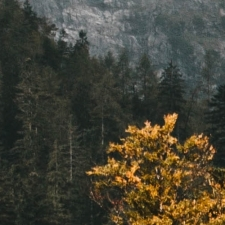

In [26]:
F_vision.to_pil_image((img4_tensor/255)[0])

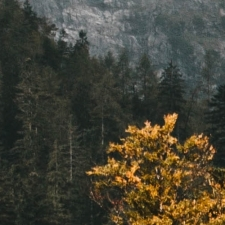

In [22]:
F_vision.to_pil_image(img4_tensor[0].to(torch.uint8))

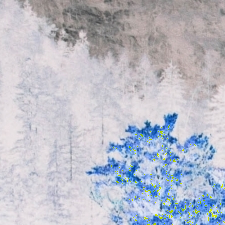

In [18]:
F_vision.to_pil_image(img4_tensor[0])

In [75]:
exp_kernels = {'identity': torch.Tensor([[[[0, 0, 0], 
                                           [0, 1, 0], 
                                           [0, 0, 0]]]]),
               
               'blur': torch.Tensor([[[[0.05, 0.1, 0.05], 
                                       [0.1, 0.2, 0.1], 
                                       [0.05, 0.1, 0.05]]]]),
               
               'sharpen': torch.Tensor([[[[0, -0.5, 0], 
                                          [-0.5, 1, -0.5], 
                                          [0, -0.5, 0]]]]),
              }

exp_kernel = exp_kernels['sharpen']

In [76]:
out1_tensor = torch.conv2d(input=img1_tensor, weight=exp_kernel, padding='same')
out1_tensor = out1_tensor/255
out2_tensor = torch.conv2d(input=img2_tensor, weight=exp_kernel, padding='same')
out2_tensor = out2_tensor/255

In [77]:
out2_tensor

tensor([[[[-0.0059, -0.2627, -0.2863,  ..., -0.2882, -0.2863, -0.0216],
          [-0.3020, -0.5784, -0.5392,  ..., -0.5549, -0.5529, -0.2765],
          [-0.2392, -0.5686, -0.5627,  ..., -0.5412, -0.5784, -0.2922],
          ...,
          [-0.1373, -0.2608, -0.2882,  ..., -0.5373, -0.5686, -0.2569],
          [-0.1882, -0.3059, -0.3196,  ..., -0.5353, -0.5686, -0.2922],
          [ 0.0392, -0.1392, -0.1490,  ..., -0.3333, -0.2804,  0.0333]]]])

In [78]:
img1_tensor

tensor([[[[121.,  76.,  86.,  ..., 117., 142., 139.],
          [ 88.,  76.,  92.,  ..., 103., 110.,  72.],
          [ 96., 151.,  68.,  ..., 108.,  60., 116.],
          ...,
          [108., 120., 120.,  ...,  97.,  81.,  85.],
          [ 95., 130., 124.,  ...,  86.,  89., 103.],
          [125., 117.,  96.,  ...,  88.,  80.,  98.]]]])

In [79]:
out1_tensor

tensor([[[[ 0.1529, -0.2569, -0.1686,  ..., -0.2353, -0.1608,  0.1255],
          [-0.2294, -0.5000, -0.2412,  ..., -0.5157, -0.3078, -0.4333],
          [-0.2549, -0.1078, -0.5294,  ..., -0.3078, -0.5569, -0.1745],
          ...,
          [-0.2392, -0.4686, -0.4922,  ..., -0.3373, -0.3843, -0.1824],
          [-0.3392, -0.3843, -0.3961,  ..., -0.3490, -0.3373, -0.1294],
          [ 0.0745, -0.2294, -0.3314,  ..., -0.1471, -0.2255,  0.0255]]]])

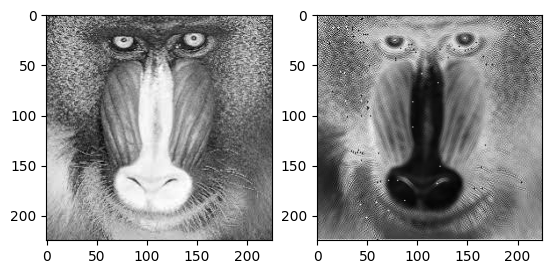

In [80]:
#img1 = ToPILImage()(img1_tensor[0].to(torch.uint8))
#out1 = ToPILImage()(out1_tensor[0].to(torch.uint8))

img1 = ToPILImage()(img1_tensor[0]/255)
out1 = ToPILImage()(out1_tensor[0])

fig, axes = plt.subplots(1,2)

axes[0].imshow(img1, cmap='gray')
axes[1].imshow(out1, cmap='gray')

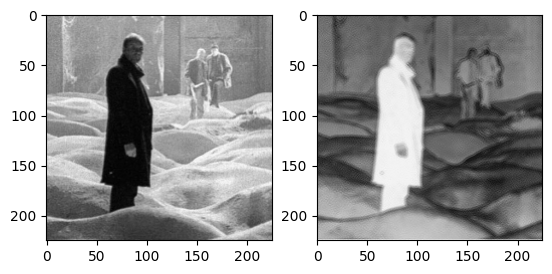

In [81]:
#img2 = ToPILImage()(img2_tensor[0].to(torch.uint8))
#out2 = ToPILImage()(out2_tensor[0].to(torch.uint8))

img2 = ToPILImage()(img2_tensor[0]/255)
out2 = ToPILImage()(out2_tensor[0])

fig, axes = plt.subplots(1,2)

axes[0].imshow(img2, cmap='gray')
axes[1].imshow(out2, cmap='gray')

In [53]:
img2_tensor[0].to(torch.float32)

tensor([[[0.5451, 0.5647, 0.5647,  ..., 0.5725, 0.5451, 0.5216],
         [0.5373, 0.5451, 0.5804,  ..., 0.5961, 0.5686, 0.5412],
         [0.5882, 0.5647, 0.5804,  ..., 0.5843, 0.5608, 0.5451],
         ...,
         [0.2784, 0.2980, 0.2902,  ..., 0.5529, 0.5451, 0.5882],
         [0.2549, 0.2745, 0.2745,  ..., 0.5569, 0.5647, 0.5922],
         [0.3333, 0.3333, 0.3373,  ..., 0.5255, 0.5725, 0.6157]]])

In [475]:
out2_tensor[0].to(torch.float32)

tensor([[[  -1.5000,  -67.0000,  -73.0000,  ...,  -73.5000,  -73.0000,
            -5.5000],
         [ -77.0000, -147.5000, -137.5000,  ..., -141.5000, -141.0000,
           -70.5000],
         [ -61.0000, -145.0000, -143.5000,  ..., -138.0000, -147.5000,
           -74.5000],
         ...,
         [ -35.0000,  -66.5000,  -73.5000,  ..., -137.0000, -145.0000,
           -65.5000],
         [ -48.0000,  -78.0000,  -81.5000,  ..., -136.5000, -145.0000,
           -74.5000],
         [  10.0000,  -35.5000,  -38.0000,  ...,  -85.0000,  -71.5000,
             8.5000]]])